In [371]:
from IPython.display import display
from math import ceil, sqrt
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

# colors generator
from itertools import cycle
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# # Algorithms
# from sklearn.cluster import KMeans
# from sklearn.metrics import pairwise_distances_argmin_min
# from sklearn.decomposition import PCA
# from tslearn.barycenters import dtw_barycenter_averaging
# Modeling
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.arima.utils import nsdiffs
from pmdarima.arima.utils import ndiffs

from sklearn.model_selection import ParameterGrid
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# assert reproducibility
import random
random.seed(7)
np.random.seed(7)
print("setup complete")

setup complete


In [372]:
sales = pd.read_csv('70prod_data.csv',\
                    index_col=0, parse_dates=True)

In [373]:
cluster_8 = sales.loc[:, ["P_3", "P_21", "P_23", "P_24", "P_56"]]
cluster_8.head()

,P_3,P_21,P_23,P_24,P_56
2014-07-31,3506,16302,21457,7204,4134
2014-08-31,3279,16907,22408,7477,4556
2014-09-30,3238,16286,21252,7592,4788
2014-10-31,3088,15147,20512,7435,4525
2014-11-30,2921,15298,22433,7434,4412


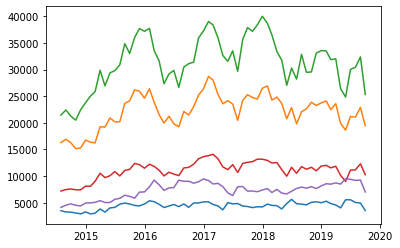

In [374]:
plt.plot(cluster_8)

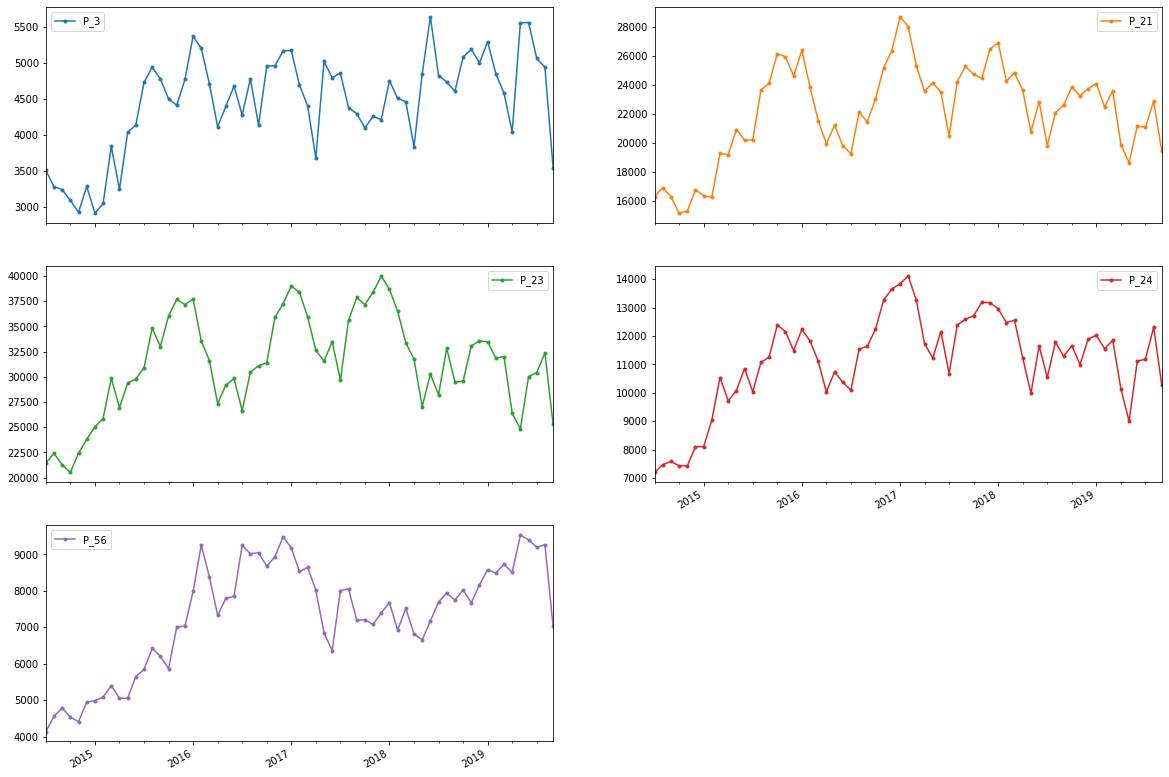

In [375]:
cluster_8.plot(subplots=True,layout=(3,2),figsize=(20,15), marker='.')
plt.show()

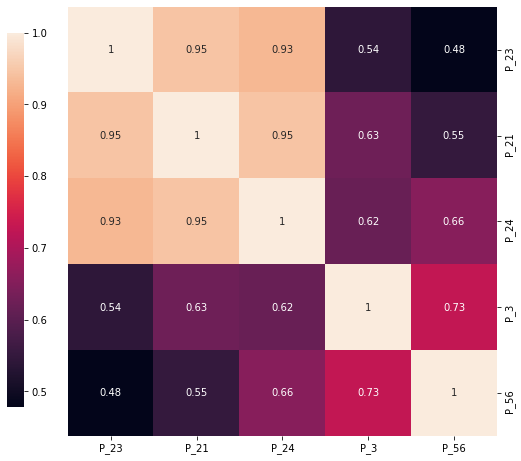

In [376]:
cg = sns.clustermap(cluster_8.corr(), figsize=(8, 8), cbar_pos=(.1, .1, .03, .65), annot=True)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
plt.show()

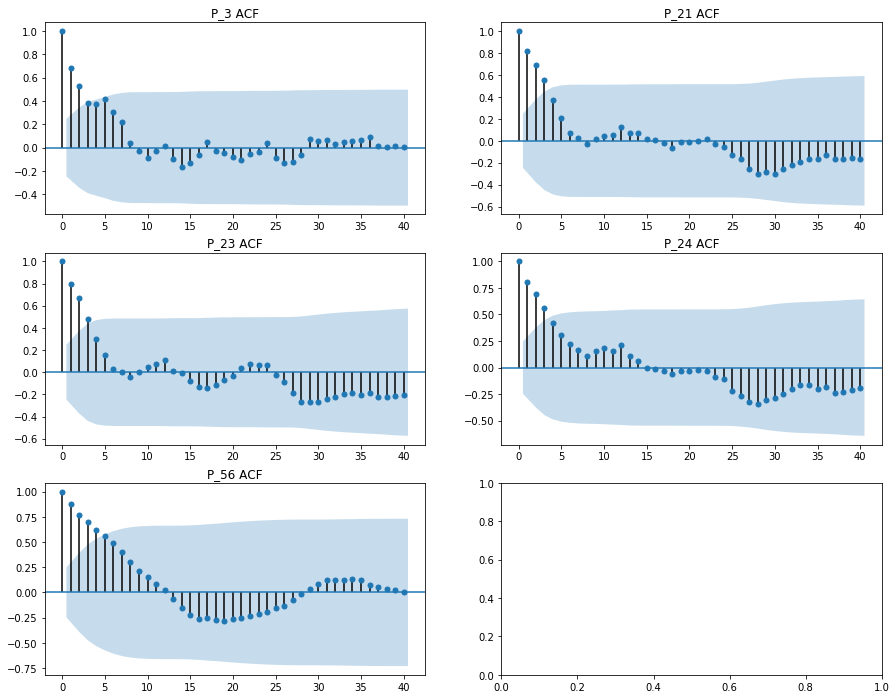

In [377]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=False)
axs = axes.flatten()
alpha=.05
for i, col in enumerate(cluster_8.columns):
    sm.graphics.tsa.plot_acf(cluster_8[col].values.squeeze(), lags=40, ax=axs[i], title=f"{col} ACF", alpha=alpha)

In [378]:
multiple_test_all(cluster_8)

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_3,Non,Oui,1,Oui,Oui,Non,1
P_21,Non,Non,0,Oui,Oui,Oui,1
P_23,Non,Oui,1,Oui,Non,Oui,1
P_24,Non,Non,0,Oui,Oui,Oui,1
P_56,Non,Non,0,Oui,Oui,Oui,1


In [379]:
def choose_d(l):
    return list(sorted(l))[1]
def Oui_non(x): 
    return "Oui" if x else "Non"
def test_all(y):
    y = y.dropna()
    n_ch = nsdiffs(remove_trend(y)["serie"].dropna(), m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(remove_trend(y)["serie"].dropna(), m=12, max_D=12, test='ocsb')
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    return (Oui_non(n_ch), Oui_non(n_ocsb), max(n_ch, n_ocsb), Oui_non(n_adf), \
            Oui_non(n_kpss), Oui_non(n_pp), choose_d((n_adf, n_kpss, n_pp)))
def multiple_test_all(df):
    res = pd.DataFrame(df.columns, columns=["Series"])
    res[1], res[2], res[3], res[4], res[5], res[6], res[7] = [[test_all(df[i])[j]\
                                               for i in df.columns] for j in range(7)]
    res=res.set_index("Series")
    res.columns = ["Canova-Hansen", "OCSB", "Seasonality Order", "ADF", "KPSS", "PP", "differencing order"]
    return res

In [380]:
def remove_trend(y):
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')
    n_diff=max(n_adf, n_kpss, n_pp)
    for i in range(n_diff):
        y = y.diff(1)
    return {"serie" : y, "n_diff" : n_diff}
def stationnarise(y):
    y ,n_diff = remove_trend(y).values()
    y = y.dropna()
    n_ch = nsdiffs(y, m=12, max_D=12, test='ch')
    n_ocsb = nsdiffs(y, m=12, max_D=12, test='ocsb')
    n_sdiff=max(n_ch, n_ocsb)
    for i in range(n_sdiff):
        y = y.diff(12)
    return {"serie" : y, "n_diff" : n_diff, "n_sdiff" : n_sdiff}

In [381]:
def series_from_summary(summary):
    return pd.DataFrame([dic['serie'] for dic in summary.values()]).T

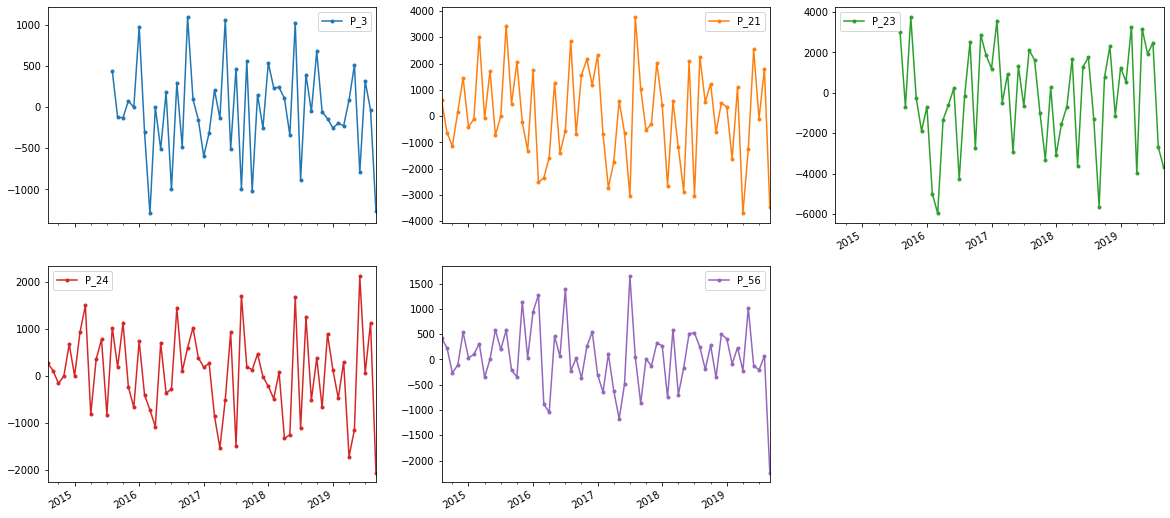

In [382]:
stationnarisation_summary  = {key: 0 for key in cluster_8.columns}
for col in cluster_8.columns:
    stationnarisation_summary[col] = stationnarise(cluster_8[col])
cluster_8_s = series_from_summary(stationnarisation_summary)
cluster_8_s.plot(subplots=True,layout=(3,3),figsize=(20,15), marker='.')
plt.show()

In [383]:
train_var = cluster_8_s.loc[:'2018-12-31']
test_var = cluster_8_s.loc['2019-01-31':] 

In [384]:
train_var

,P_3,P_21,P_23,P_24,P_56
2014-08-31,NaN,605.0,NaN,273.0,422.0
2014-09-30,NaN,-621.0,NaN,115.0,232.0
2014-10-31,NaN,-1139.0,NaN,-157.0,-263.0
2014-11-30,NaN,151.0,NaN,-1.0,-113.0
2014-12-31,NaN,1465.0,NaN,675.0,537.0
2015-01-31,NaN,-409.0,NaN,2.0,34.0
2015-02-28,NaN,-108.0,NaN,930.0,99.0
2015-03-31,NaN,3028.0,NaN,1498.0,316.0
2015-04-30,NaN,-77.0,NaN,-815.0,-350.0
2015-05-31,NaN,1725.0,NaN,353.0,7.0


In [385]:
multiple_test_all(cluster_8_s)

,Canova-Hansen,OCSB,Seasonality Order,ADF,KPSS,PP,differencing order
Series,,,,,,,
P_3,Non,Non,0,Non,Non,Non,0
P_21,Non,Non,0,Non,Non,Non,0
P_23,Non,Non,0,Oui,Non,Non,0
P_24,Non,Non,0,Non,Non,Non,0
P_56,Non,Non,0,Non,Non,Non,0


In [386]:
stationnarisation_summary

{'P_3': {'serie': 2014-08-31       NaN
  2014-09-30       NaN
  2014-10-31       NaN
  2014-11-30       NaN
  2014-12-31       NaN
                 ...  
  2019-05-31     510.0
  2019-06-30    -793.0
  2019-07-31     318.0
  2019-08-31     -36.0
  2019-09-30   -1266.0
  Name: P_3, Length: 62, dtype: float64,
  'n_diff': 1,
  'n_sdiff': 1},
 'P_21': {'serie': 2014-08-31     605.0
  2014-09-30    -621.0
  2014-10-31   -1139.0
  2014-11-30     151.0
  2014-12-31    1465.0
                 ...  
  2019-05-31   -1246.0
  2019-06-30    2539.0
  2019-07-31     -95.0
  2019-08-31    1805.0
  2019-09-30   -3463.0
  Name: P_21, Length: 62, dtype: float64,
  'n_diff': 1,
  'n_sdiff': 0},
 'P_23': {'serie': 2014-08-31       NaN
  2014-09-30       NaN
  2014-10-31       NaN
  2014-11-30       NaN
  2014-12-31       NaN
                 ...  
  2019-05-31    3167.0
  2019-06-30    1928.0
  2019-07-31    2482.0
  2019-08-31   -2698.0
  2019-09-30   -3693.0
  Name: P_23, Length: 62, dtype: float64,
  

In [387]:
from statsmodels.tsa.stattools import grangercausalitytests

In [388]:
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]].dropna(), maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset
grangers_causality_matrix(train_var, variables = train_var.columns)

,P_3_x,P_21_x,P_23_x,P_24_x,P_56_x
P_3_y,1.0000,0.0000,0.0,0.0000,0.0000
P_21_y,0.0000,1.0000,0.0,0.0000,0.0000
P_23_y,0.0000,0.0000,1.0,0.0000,0.0067
P_24_y,0.0000,0.0000,0.0,1.0000,0.0193
P_56_y,0.1915,0.0123,0.0,0.0001,1.0000


In [389]:
# from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VAR

from scipy.stats import pearsonr

In [390]:
mod = VAR(endog=train_var.dropna())
# res = mod.fit(maxlags=6, ic='aic')
# print(res.summary())

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [489]:
model_fit = mod.fit(maxlags=12)
prediction = model_fit.forecast(model_fit.y, steps=len(test_var))

In [490]:
# model_fit.summary()

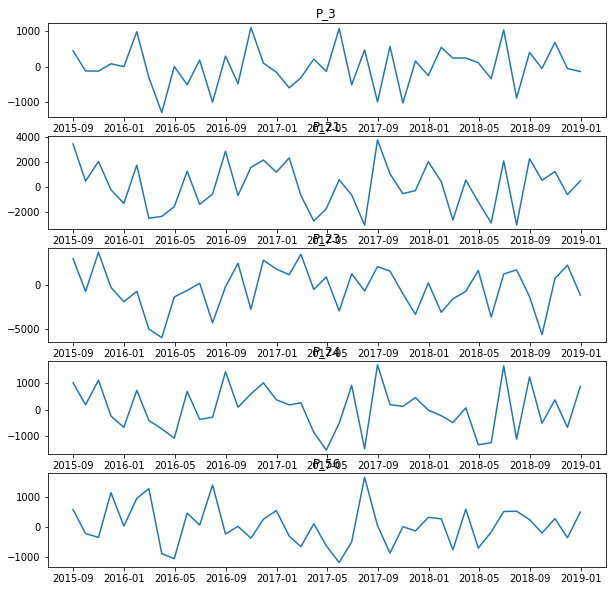

In [491]:
model_fit.plot();

In [492]:
# model_fit.summary()

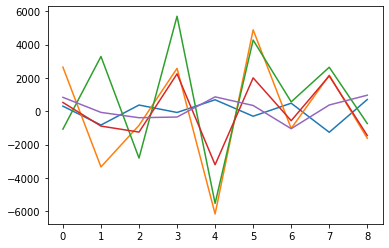

In [493]:
plt.plot(prediction)

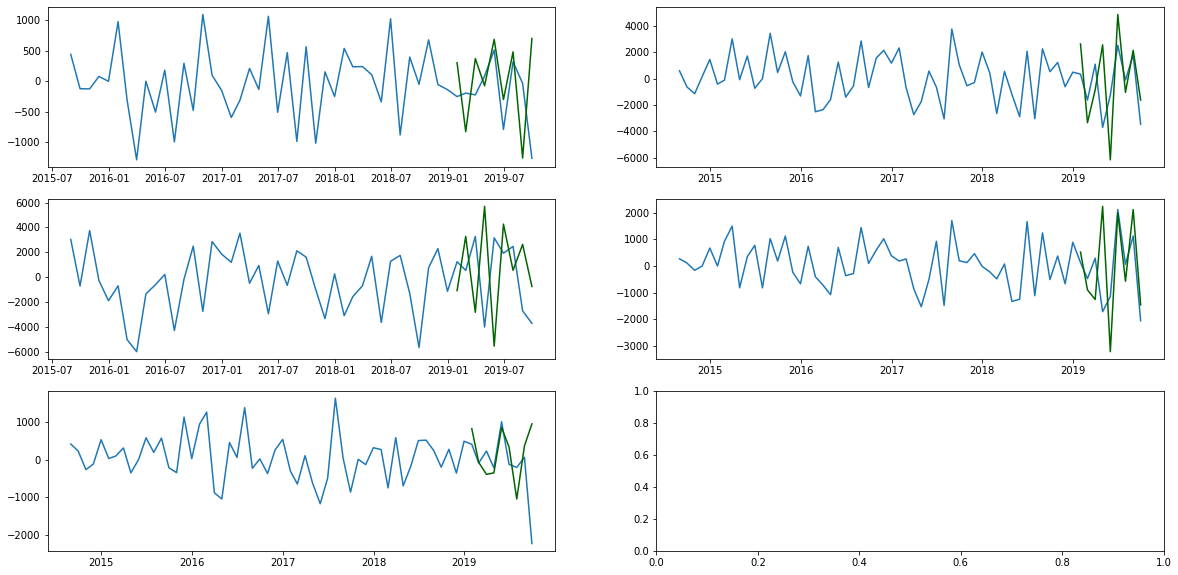

In [494]:
fig, axs = plt.subplots(3, 2, figsize=(20, 10))
axs = axs.flatten()
# index_of_fc = sales_s.loc['2019-01-31':].index
for i, p in enumerate(prediction.T) :
    fc_series = pd.Series(p, index=cluster_8.loc['2019-01-31':].index)
    axs[i].plot(cluster_8_s.iloc[:,i], label="actual")
    axs[i].plot(fc_series, color='darkgreen', label="forecast")

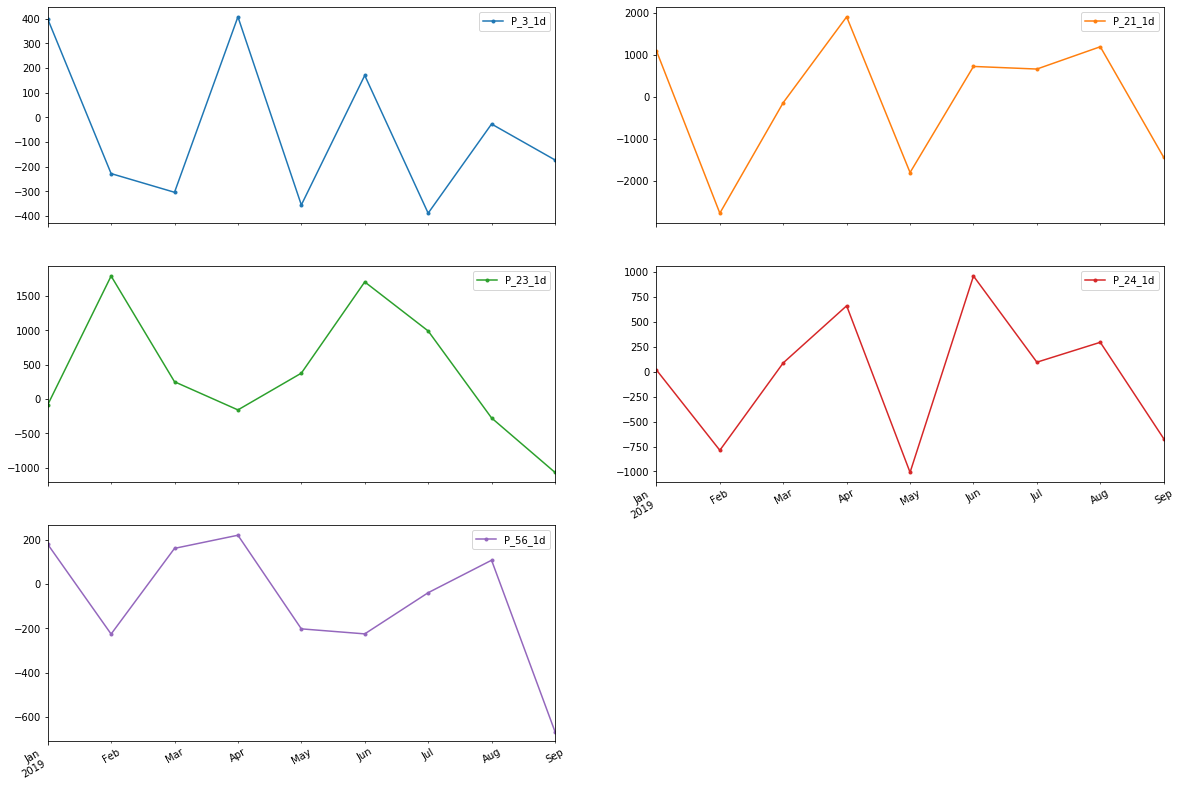

In [495]:
df_forecast.plot(subplots=True,layout=(3,2),figsize=(20,15), marker='.')
plt.show()

In [496]:
# forecasting
pred = prediction
df_forecast = pd.DataFrame(pred, index=cluster_8_s.index[-9:], columns=cluster_8_s.columns + '_1d')
df_forecast.tail()


,P_3_1d,P_21_1d,P_23_1d,P_24_1d,P_56_1d
2019-05-31,686.128873,-6158.009112,-5525.861093,-3208.796773,860.516840
2019-06-30,-301.391448,4880.270380,4266.503872,1999.368709,343.387432
2019-07-31,480.431806,-1033.883168,560.753086,-568.493709,-1047.517109
2019-08-31,-1261.846911,2160.611576,2636.591699,2116.807230,373.023914
2019-09-30,701.057304,-1621.222973,-737.864983,-1454.944330,960.352128


In [497]:
df_forecast[['P_24_1d']]

,P_24_1d
2019-01-31,525.079328
2019-02-28,-891.696568
2019-03-31,-1252.046910
2019-04-30,2239.870123
2019-05-31,-3208.796773
2019-06-30,1999.368709
2019-07-31,-568.493709
2019-08-31,2116.807230
2019-09-30,-1454.944330


In [498]:
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation( cluster_8[['P_24']].loc[:'2018-12-31'], df_forecast[['P_24_1d']])        
temp = df_results[['P_24_forecast']]
temp

,P_24_forecast
2019-01-31,12416.079328
2019-02-28,11524.382761
2019-03-31,10272.335850
2019-04-30,12512.205974
2019-05-31,9303.409200
2019-06-30,11302.777909
2019-07-31,10734.284200
2019-08-31,12851.091429
2019-09-30,11396.147100


In [499]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    acf1 = acf(forecast-actual)[1]              # ACF1
    return({'mape':mape, 'mae': mae, 'rmse':rmse, 'acf1':acf1, 'corr':corr})

6 lags : 'mape': 0.16701574989829326

12 lags : 'mape': 0.07184507579667153

13 lags : 'mape': 0.09970934676146014

14 lags : 'mape': 0.09265757161706283

15 lags : 'mape': 0.08314850542845592

In [500]:
forecast_accuracy(temp['P_24_forecast'], cluster_8['P_24'].loc['2019-01-31':])

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


{'mape': 0.07184507579667153,
 'mae': 775.3009033022895,
 'rmse': 1063.261182543626,
 'acf1': -0.3436643006440833,
 'corr': 0.528893980253092}

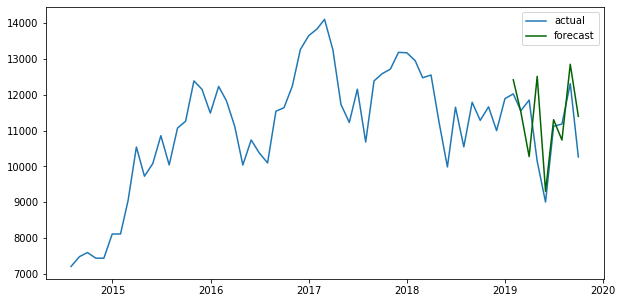

In [501]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(cluster_8[['P_24']], label="actual")
axs.plot(temp, color='darkgreen', label="forecast")
axs.legend();